# Load data

In [1]:
import json

with open('../results/soft_vs_informed_simul.json', 'r') as f:
    data_v1 = json.load(f)

with open('../results/soft_vs_informed_simul_v2.json', 'r') as f:
    data_v2 = json.load(f)


In [9]:
print(list(data_v2.keys())[0])

(5, 5)


# Plot

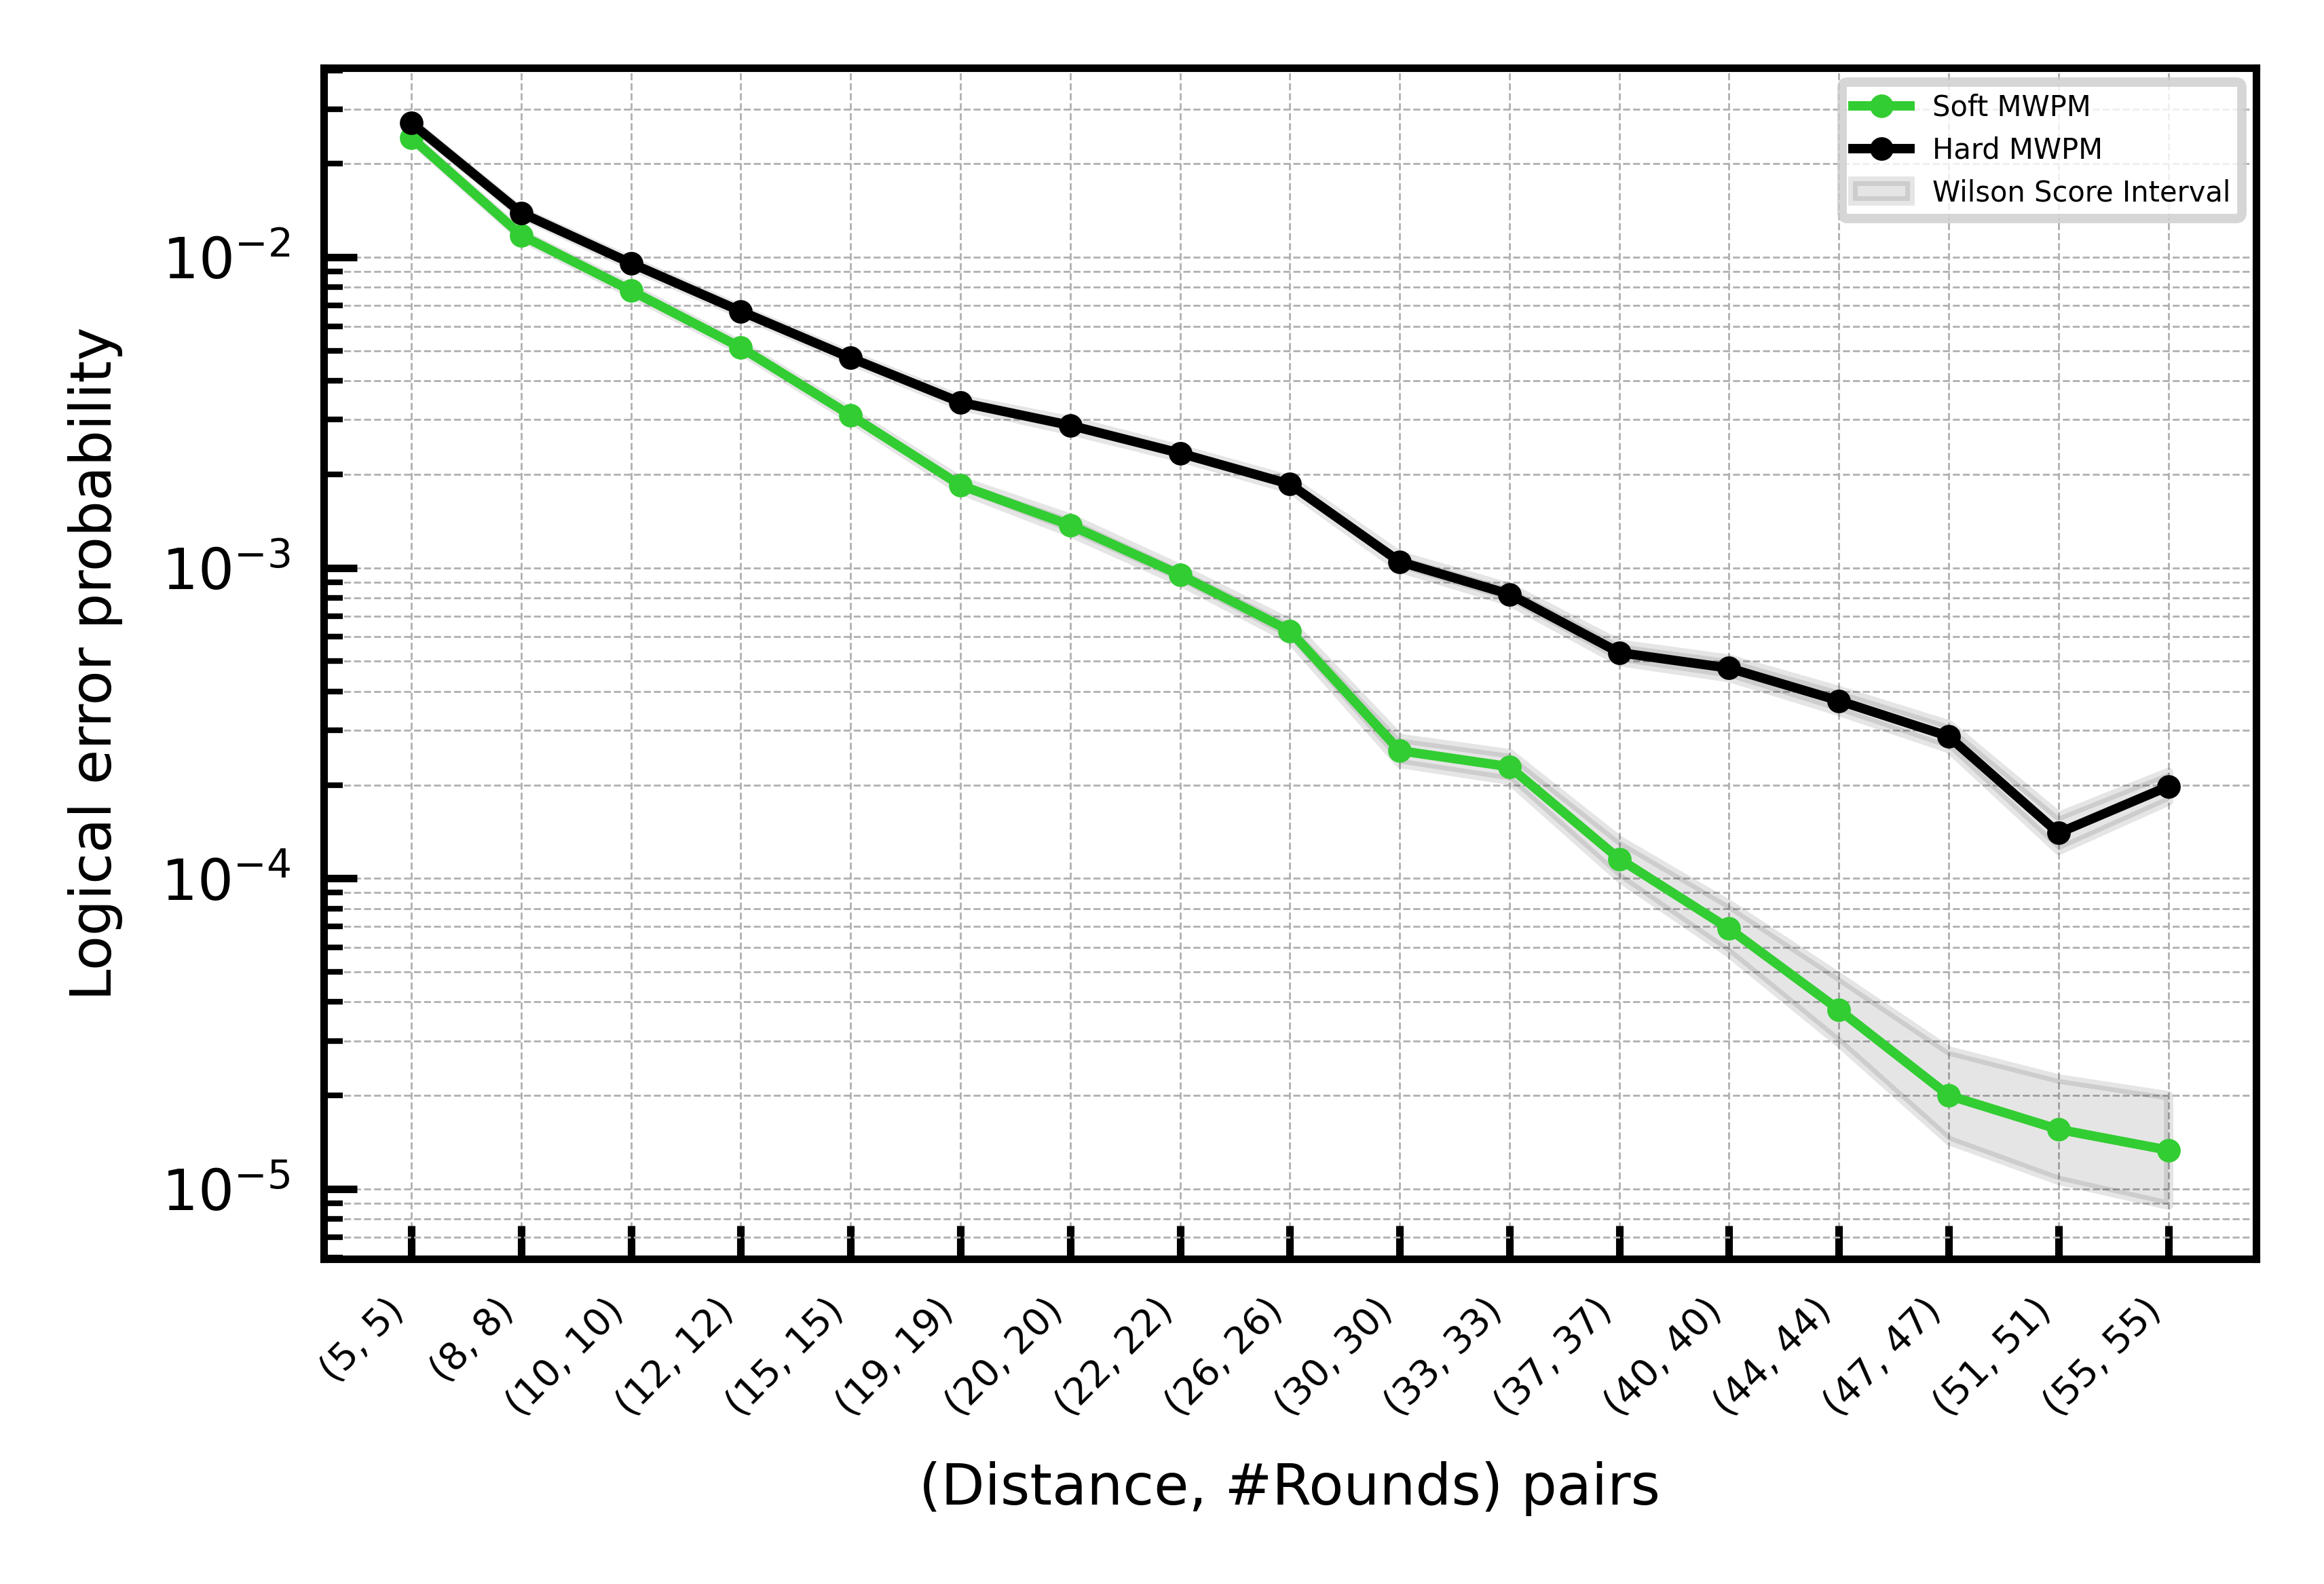

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

FIGURE_WIDTH_1COL = 3.404  # For PRX style, change for according to journal
FIGURE_WIDTH_2COL = 7.057  # For PRX style, change for according to journal
FIGURE_HEIGHT_1COL_GR = FIGURE_WIDTH_1COL*2/(1 + np.sqrt(5))*1.1
FIGURE_HEIGHT_2COL_GR = FIGURE_WIDTH_2COL*2/(1 + np.sqrt(5))*1.1

font_size = 6 # For PRX style, change for according to journal

plt.rcParams.update({
    'font.size'           : font_size,  
    'figure.titlesize'    : 'medium',
    'figure.dpi'          : 1000,
    'figure.figsize'      : (FIGURE_WIDTH_1COL, FIGURE_HEIGHT_1COL_GR),
    'axes.titlesize'      : 'medium',
    'axes.axisbelow'      : True,
    'xtick.direction'     : 'in',
    'xtick.labelsize'     : 'small',
    'ytick.direction'     : 'in',
    'ytick.labelsize'     : 'small',
    'image.interpolation' : 'none',
    'legend.fontsize'     : font_size,
    'axes.labelsize'      : font_size,
    'axes.titlesize'      : font_size,
    'xtick.labelsize'     : font_size,
    'ytick.labelsize'     : font_size,
})


plt.rcParams.update({'font.family':'sans-serif'})

# Assuming data_v1 and data_v2 are defined elsewhere in your code

# Calculate Wilson score interval
def wilson_score_interval(p, n, z=1): # 1 for 68% confidence interval
    denominator = 1 + z**2 / n
    term = z * np.sqrt(p * (1 - p) / n + z**2 / (4 * n**2))
    lower = (p + z**2 / (2 * n) - term) / denominator
    upper = (p + z**2 / (2 * n) + term) / denominator
    return max(lower, 0), upper

# Initialize plotting data
grid_rates = []
grid_lowers = []
grid_uppers = []
informed_rates = []
informed_lowers = []
informed_uppers = []
pairs = []  # For x-axis labels

# Process data
# needed_pairs = [str((10, 10)), str((20, 20)), str((30, 35)), str((40, 35)), str((55, 35))]
needed_pairs = [str((i, i)) for i in [5, 8, 10, 12, 15, 19, 20, 22, 26, 30, 33, 37, 40, 44, 47, 51, 55]]

for pair, dict in data_v2.items():
    if pair not in needed_pairs:
        continue
    pairs.append(pair)  # Add pair name for x-axis label
    shots = dict["shots"]
    if pair in data_v1:
        shots += data_v1[pair]["shots"]
        err_rate_grid = (dict["grid"] + data_v1[pair]["grid"]) / shots
        err_rate_informed = (dict["informed"] + data_v1[pair]["informed"]) / shots
    else:
        err_rate_grid = dict["grid"] / shots
        err_rate_informed = dict["informed"] / shots

    # Calculate Wilson score intervals for grid and informed
    lower_grid, upper_grid = wilson_score_interval(err_rate_grid, shots)
    lower_informed, upper_informed = wilson_score_interval(err_rate_informed, shots)
    
    # Store data for plotting
    grid_rates.append(err_rate_grid)
    grid_lowers.append(lower_grid)
    grid_uppers.append(upper_grid)
    informed_rates.append(err_rate_informed)
    informed_lowers.append(lower_informed)
    informed_uppers.append(upper_informed)

# Plotting
fig, ax = plt.subplots()

# # Grid error rates and intervals
grid_x = np.arange(len(pairs))  # x positions for grid points
plt.plot(grid_x, grid_rates, 'o-', color='limegreen', label="Soft MWPM", markersize=1.5, linewidth=1)
plt.fill_between(grid_x, grid_lowers, grid_uppers, color='black', alpha=0.1)
# plt.plot(grid_x, grid_rates, 'o-', color='black', label="Soft MWPM", markersize=0, linewidth=0)
# plt.fill_between(grid_x, grid_lowers, grid_uppers, color='black', alpha=0)

# Informed error rates and intervals
informed_x = np.arange(len(pairs))  # x positions for informed points
plt.plot(informed_x, informed_rates, 'o-', color='black', label="Hard MWPM", markersize=1.5, linewidth=1)
plt.fill_between(informed_x, informed_lowers, informed_uppers, color='black', alpha=0.1)

# Customize the plot
ax.set_xticks(grid_x)
ax.set_xticklabels(pairs, rotation=45, ha="right", fontsize=4)
ax.set_yscale("log")
# plt.yticks(ticks=[0.00001, 0.0001, 0.001, 0.01], labels=["0.001%", "0.01%", "0.1%", "1%"], fontsize=4)
ax.set_xlabel("(Distance, #Rounds) pairs") 
ax.set_ylabel("Logical error probability")
plt.grid(True, which="both", ls="--", linewidth=0.2)
error_patch = mpatches.Patch(color='black', alpha=0.1, label='Error Region')

current_handles, current_labels = plt.gca().get_legend_handles_labels()
current_handles.append(error_patch)  # Append the error_patch to the existing handles

# Now call plt.legend() with the updated handles
plt.legend(handles=current_handles, labels=current_labels + ['Wilson Score Interval'], fontsize=3)
# plt.title("Simulation: Logical err. rate for different (distance, #rounds) pairs")

plt.tight_layout()
plt.show()
